# Single Shot Detection with fastai

### Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

In [3]:
torch.backends.cudnn.benchmark=True

### General helper functions

In [4]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
    return trn_anno

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)
    
def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    k=0
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>1) and (pr is None or pr > thresh)):
            k+=1
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{k}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])
    
# function to convert centers and sizes to corners
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()
    
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

def show_nmf(idx):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > 0.25
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    if not cc:
        print(f"{i}: empty array")
        return
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, ax = plt.subplots(figsize=(8,8))
    torch_gt(ax, ima, out2, cc, out1, 0.1)

### NN architectures and datasets (classes and related functions)

In [5]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))
    
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]
    
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv2(x)
        return self.out(x)
    
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None
    
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1) # 3
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0) # 16
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]
    
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

## Set up dataset

In [6]:
PATH = Path(r'C:\Users\Francesco\Notebooks\personal\data\pascal')
trn_j = json.load((PATH / 'pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

In [7]:
trn_anno = get_trn_anno()

In [8]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

f_model=resnet34
sz=224
bs=64

In [9]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc])

In [10]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [11]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn','bbox'])
df.to_csv(MBB_CSV, index=False)
df.head()

fn                                               bbox
0  000012.jpg                                     96 155 269 350
1  000017.jpg                       61 184 198 278 77 89 335 402
2  000023.jpg  229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3  000026.jpg                                     124 89 211 336
4  000032.jpg  77 103 182 374 87 132 122 196 179 194 228 212 ...

In [12]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, bs=bs, continuous=True, num_workers=4)

In [13]:
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [14]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [15]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)
x.shape, y[0].shape, y[1].shape

((64, 224, 224, 3), (64, 56), (64, 14))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


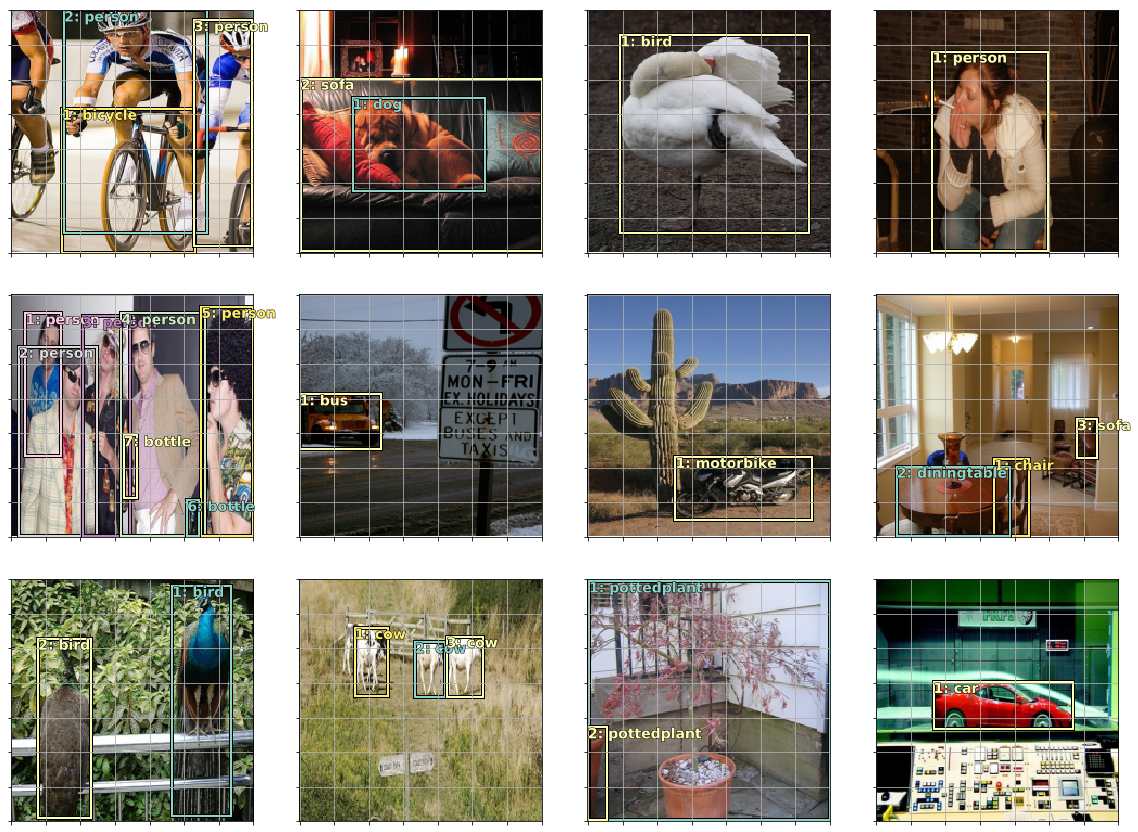

In [16]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

## First SSD model

We're going to make a simple first model that simply predicts what object is located in each cell of a 4x4 grid. Later on we can try to improve this.

In [17]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [18]:
#anc_ctrs

In [19]:
#anchors # this represents the center of the anchor boxes with height and width (they are 0.25 squares)

In [20]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)
#grid_sizes

In [21]:
#plt.scatter(anc_x, anc_y)
#plt.xlim(0, 1)
#plt.ylim(0, 1);

In [22]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
#anchor_cnr

In [23]:
#n_clas = len(id2cat)+1
#n_act = k*(4+n_clas)
#n_act

In [24]:
#x_ = V(np.random.rand(64,3,224,224)).cpu()
#conv = StdConv(3, 10)
#conv(x_).shape

In [25]:
#bs,nf,gx,gy = conv(x_).size()

In [26]:
#conv(x_).permute(0,2,3,1).contiguous().view(bs,-1,nf//1).shape

In [27]:
head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [28]:
#learn.summary()

In [29]:
x = V(np.random.rand(64,512,7,7))
print(x.size())
x = head_reg4.sconv0(x)
print(x.size())
x = head_reg4.sconv2(x)
print(x.size())
out1, out2 = head_reg4.out(x)
print(out1.size(), out2.size())

torch.Size([64, 512, 7, 7])
torch.Size([64, 256, 7, 7])
torch.Size([64, 256, 4, 4])
torch.Size([64, 16, 21]) torch.Size([64, 16, 4])


In [30]:
#x_2.shape

In [31]:
#out[1].shape

### Train

In [32]:
loss_f = BCE_Loss(len(id2cat))

In [33]:
# pred = batch
# targ = y

# lcs,lls = 0.,0.
# for b_c,b_bb,bbox,clas in zip(*pred,*targ):
#     #pdb.set_trace()
#     loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,False)
#     lls += loc_loss
#     lcs += clas_loss
#     break

In [34]:
# b_c #classes predictions 16,21
# b_bb #bb predictions 16,4
# bbox #56 dimensional tensor (14,4) containing actual bboxes (only 3 bbox, rest is padded wirh 0)
# clas; #14 dimensional tensor (14,1) containing actual classes (only 3 one per bbox)

In [35]:
# def get_y(bbox,clas):
#     bbox = bbox.view(-1,4)/sz
#     bb_#keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
#     return bbox[bb_keep],clas[bb_keep]

# bbox,clas = get_y(bbox,clas) # returns the scaled bboxes (by 224) and the corresponding classes (only the 3 non zeros)

In [36]:
# clas

In [37]:
# grid_sizes

In [38]:
# def actn_to_bb(actn, anchors):
#     actn_bbs = torch.tanh(actn) # squashing activations (bbxes between -1 and 1)
#     actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
#     actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
#     return hw2corners(actn_centers, actn_hw)

# a_ic = actn_to_bb(b_bb, anchors)
# a_ic

In [39]:
#clas0

In [40]:
#x,y = next(iter(md.val_dl))
# x,y = V(x).cpu(),V(y)
#x,y = V(x),V(y)

In [41]:
#for i,o in enumerate(y): y[i] = o.cuda()
#learn.model.cuda()

In [42]:
#batch = learn.model(x)

In [43]:
#batch[0].shape

In [44]:
#id2cat[1]

In [45]:
#y[1].size()

In [46]:
 # uncomment to debug on cpu
#anchors = anchors.cpu(); grid_sizes = grid_sizes.cpu(); anchor_cnr = anchor_cnr.cpu()

In [47]:
#_ = ssd_loss(batch, y, True)

In [58]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

epoch      trn_loss   val_loss                                                                                                                                                                                                              
    0      105.65898  22098.605391



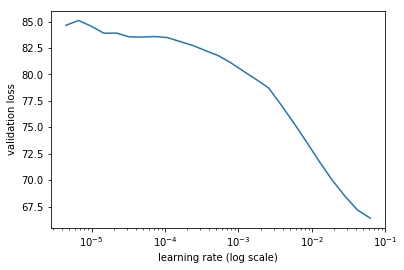

In [59]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(1)

In [60]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

epoch      trn_loss   val_loss                                                                                                                                                                                                              
    0      43.001565  31.549975 
    1      33.59092   28.610656                                                                                                                                                                                                             
    2      29.400848  26.712649                                                                                                                                                                                                             
    3      26.551586  26.045135                                                                                                                                                                                                             
    4      24.34914

[array([25.65222])]

In [61]:
learn.save('0')

In [62]:
learn.load('0')

In [63]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch

In [64]:
#b_clas.size(),b_bb.size()

In [65]:
#y[0][idx].view(-1, 4)

In [66]:
# idx=7
# b_clasi = b_clas[idx]
# b_bboxi = b_bb[idx]
# ima=md.val_ds.ds.denorm(to_np(x))[idx]
# bbox,clas = get_y(y[0][idx], y[1][idx])
# bbox,clas

In [67]:
#b_clasi.size()

In [68]:
# def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
#     bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
#     if prs is None:  prs  = [None]*len(bb)
#     if clas is None: clas = [None]*len(bb)
#     ax = show_img(im, ax=ax)
#     k=0
#     for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
#         if((b[2]>1) and (pr is None or pr > thresh)):
#             k+=1
#             draw_rect(ax, b, color=colr_list[i%num_colr])
#             txt = f'{k}: '
#             if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
#             if pr is not None: txt += f' {pr:.2f}'
#             draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [69]:
#to_np((bbox*224).long())

In [70]:
#[id2cat[to_np(i)[0]] for i in clas]

In [71]:
#fig, ax = plt.subplots(figsize=(7,7))
#torch_gt(ax, ima, bbox, clas)

In [72]:
#fig, ax = plt.subplots(figsize=(7,7))
#torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

In [73]:
#grid_sizes

In [74]:
#anchors

In [75]:
#b_bboxi.size()

In [76]:
#a_ic = actn_to_bb(b_bboxi, anchors)

In [77]:
#fig, ax = plt.subplots(figsize=(7,7))
#torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)

In [78]:
# def intersect(box_a, box_b):
#     max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
#     min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
#     inter = torch.clamp((max_xy - min_xy), min=0)
#     return inter[:, :, 0] * inter[:, :, 1]

# def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

# def jaccard(box_a, box_b):
#     inter = intersect(box_a, box_b)
#     print(inter)
#     union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
#     return inter / union

In [79]:
#torch.clamp()

In [80]:
#bbox.data#.size(), anchor_cnr.data.size()

In [81]:
#bbox.data[:, None, 2:], anchor_cnr.data[:, None, 2:]

In [82]:
#torch.min(bbox.data[:, None, 2:], anchor_cnr.data[None, :, 2:])

In [83]:
#overlaps = jaccard(bbox.data, anchor_cnr.data)
#overlaps

In [84]:
#overlaps.max(1)

In [85]:
#overlaps.max(0)[0]

In [86]:
#gt_overlap,gt_idx = map_to_ground_truth(overlaps)
#gt_overlap,gt_idx

In [87]:
#gt_idx, clas

In [88]:
#gt_clas = clas[gt_idx]; gt_clas

In [89]:
# thresh = 0.5
# pos = gt_overlap > thresh
# pos_idx = torch.nonzero(pos)[:,0]
# neg_idx = torch.nonzero(1-pos)[:,0]
# pos_idx, neg_idx

In [90]:
#pos

In [91]:
#gt_clas[1-pos] = len(id2cat)
#[id2cat[o] if o<len(id2cat) else 'bg' for o in gt_clas.data]

In [92]:
#bbox[gt_idx]

In [93]:
#gt_clas.size()

In [94]:
# gt_bbox = bbox[gt_idx]
# loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
# clas_loss  = F.cross_entropy(b_clasi, gt_clas)
# loc_loss,clas_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


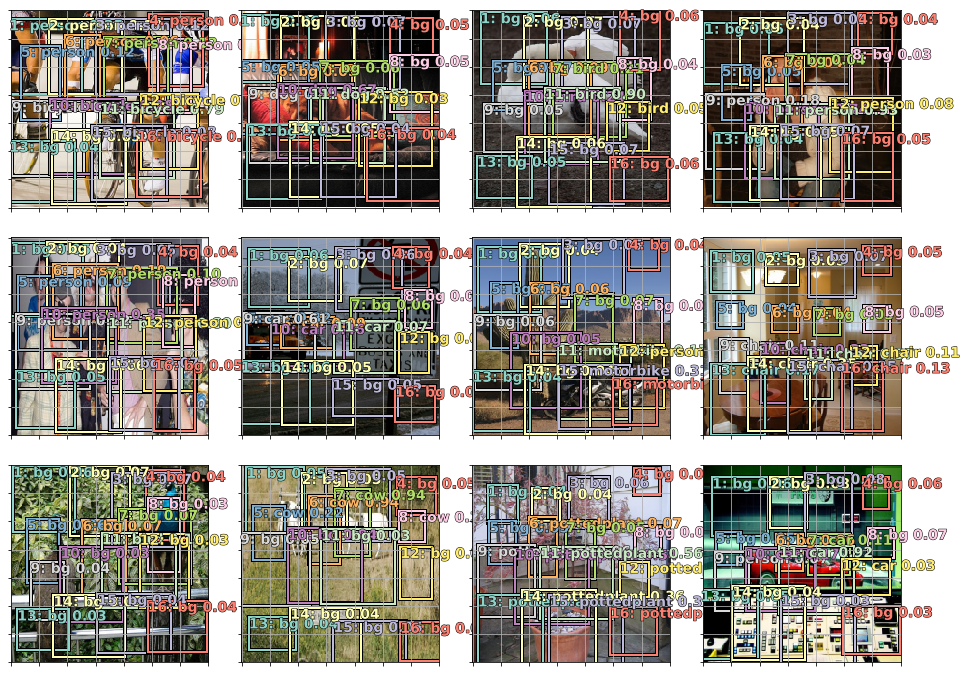

In [95]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(bbox,clas); bbox,clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
#plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.15)

## Improving SSD model adding anchors

### Create anchors

In [48]:
anc_grids = [4,2,1]
# anc_grids = [2]
anc_zooms = [0.7, 1., 1.3]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

9

In [97]:
#anc_offsets

In [49]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [99]:
#anc_ctrs.shape

In [50]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [101]:
#anchor_cnr

In [51]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

In [52]:
a=np.reshape((to_np(anchor_cnr) + to_np(torch.randn(*anchor_cnr.size()))*0.01)*224, -1)

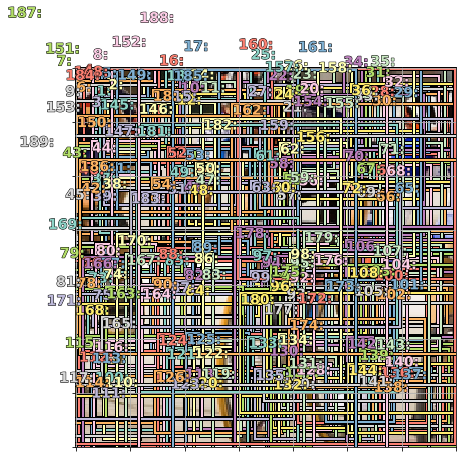

In [53]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

In [105]:
#fig, ax = plt.subplots(figsize=(7,7))
#show_ground_truth(ax, x[0], a)

### Model

In [54]:
drop=0.4

head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [50]:
#learn.summary()

In [49]:
#learn

In [60]:
#out = OutConv(k, 256, -4.)

In [108]:
#out

In [55]:
x = V(torch.randn(64, 512, 7, 7))
x.size()

torch.Size([64, 512, 7, 7])

In [56]:
x = head_reg4.drop(F.relu(x))
x.size()

torch.Size([64, 512, 7, 7])

In [57]:
x = head_reg4.sconv0(x)
x.size()

torch.Size([64, 256, 7, 7])

In [58]:
x = head_reg4.sconv1(x)
x.size()

torch.Size([64, 256, 4, 4])

In [63]:
#o1c, o1l = out(x.cpu())
#o1c.size(), o1l.size()

In [114]:
#x.size()

In [115]:
#out.oconv1(x.cpu()).size()

In [116]:
#4*4*9

In [117]:
#189//9

In [64]:
o1c, o1l = head_reg4.out1(x)
o1c.size(), o1l.size()

(torch.Size([64, 144, 21]), torch.Size([64, 144, 4]))

In [65]:
x = head_reg4.sconv2(x)
x.size()

torch.Size([64, 256, 2, 2])

In [66]:
o2c, o2l = head_reg4.out2(x)
o2c.size(), o2l.size()

(torch.Size([64, 36, 21]), torch.Size([64, 36, 4]))

In [67]:
x = head_reg4.sconv3(x)
x.size()

torch.Size([64, 256, 1, 1])

In [68]:
o3c, o3l = head_reg4.out3(x)
o3c.size(), o3l.size()

(torch.Size([64, 9, 21]), torch.Size([64, 9, 4]))

In [69]:
torch.cat([o1c,o2c,o3c], dim=1).size(), torch.cat([o1l,o2l,o3l], dim=1).size()

(torch.Size([64, 189, 21]), torch.Size([64, 189, 4]))

In [124]:
#k

In [125]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])

In [126]:
#x,y = next(iter(md.val_dl))
#x,y = V(x),V(y)
#batch = learn.model(V(x))

In [127]:
#batch[0].size(),batch[1].size()

In [128]:
#ssd_loss(batch, y, True)

epoch      trn_loss   val_loss                                                                                                                                                                                                              
    0      347.42654  1709264.716



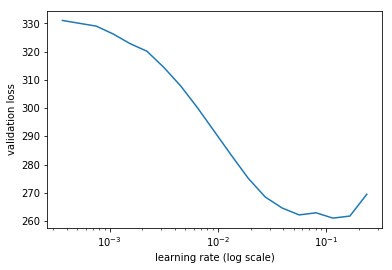

In [129]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=2)

In [130]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss                                                                                                                                                                                                              
    0      158.744018 138.411011
    1      126.200522 102.456258                                                                                                                                                                                                            
    2      107.669251 92.414301                                                                                                                                                                                                             
    3      95.350135  87.756209                                                                                                                                                                                                             



[array([87.75621])]

In [131]:
learn.save('tmp')

In [132]:
learn.freeze_to(-2)
learn.fit(lrs/2, 1, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss                                                                                                                                                                                                              
    0      91.047717  112.497854
    1      85.137055  84.81217                                                                                                                                                                                                              
    2      76.940319  79.028046                                                                                                                                                                                                             
    3      70.026988  76.108328                                                                                                                                                                                                             



[array([76.10833])]

In [133]:
learn.save('prefocal')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


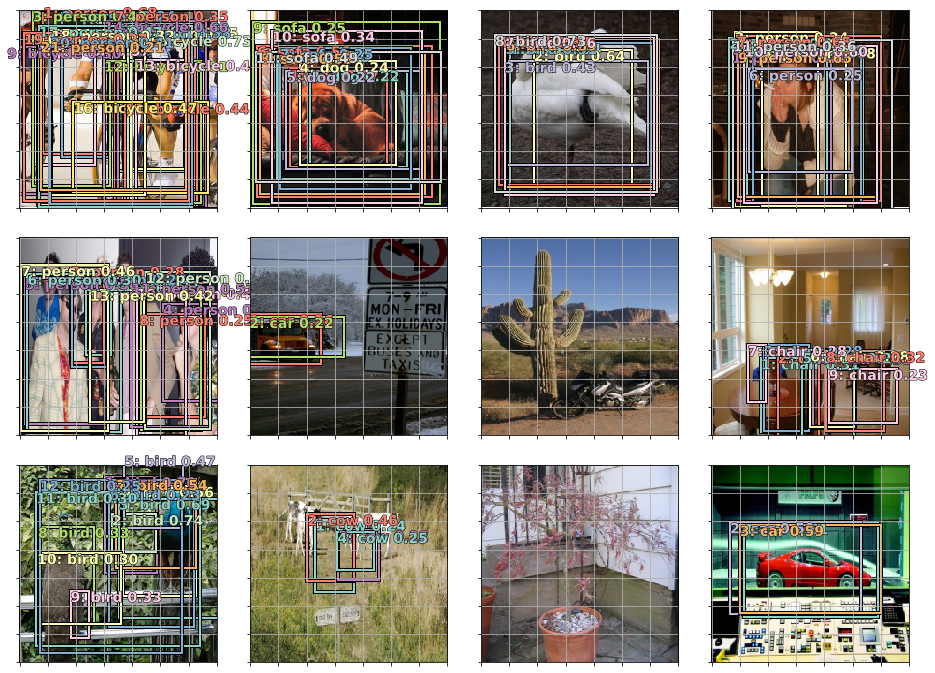

In [134]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.21)
#plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.15)

## Cherry on top with Focal loss

In [135]:
loss_f = FocalLoss(len(id2cat))

In [136]:
#x,y = next(iter(md.val_dl))
#x,y = V(x),V(y)
#batch = learn.model(x)
#ssd_loss(batch, y, True)

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 30/32 [00:36<00:02,  1.00s/it, loss=59.9]

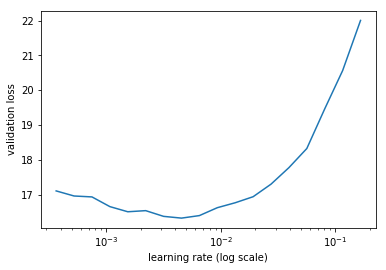

In [137]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=1)

In [138]:
learn.fit(lrs, 1, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss                                                                                                                                                                                                              
    0      18.598823  40.276583 
    1      21.761929  40.439404                                                                                                                                                                                                             
    2      21.130506  20.51665                                                                                                                                                                                                              
    3      19.738076  19.845055                                                                                                                                                                                                             
    4      18.48606

[array([16.58816])]

In [139]:
learn.save('fl0')

In [140]:
learn.load('fl0')

In [141]:
learn.freeze_to(-2)
learn.fit(lrs/4, 1, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss                                                                                                                                                                                                              
    0      12.508478  16.88196  
    1      12.587664  17.298873                                                                                                                                                                                                             
    2      12.35257   16.441807                                                                                                                                                                                                             
    3      12.078453  16.811768                                                                                                                                                                                                             
    4      11.62379

[array([16.3113])]

In [142]:
learn.save('drop4')

In [143]:
learn.load('drop4')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


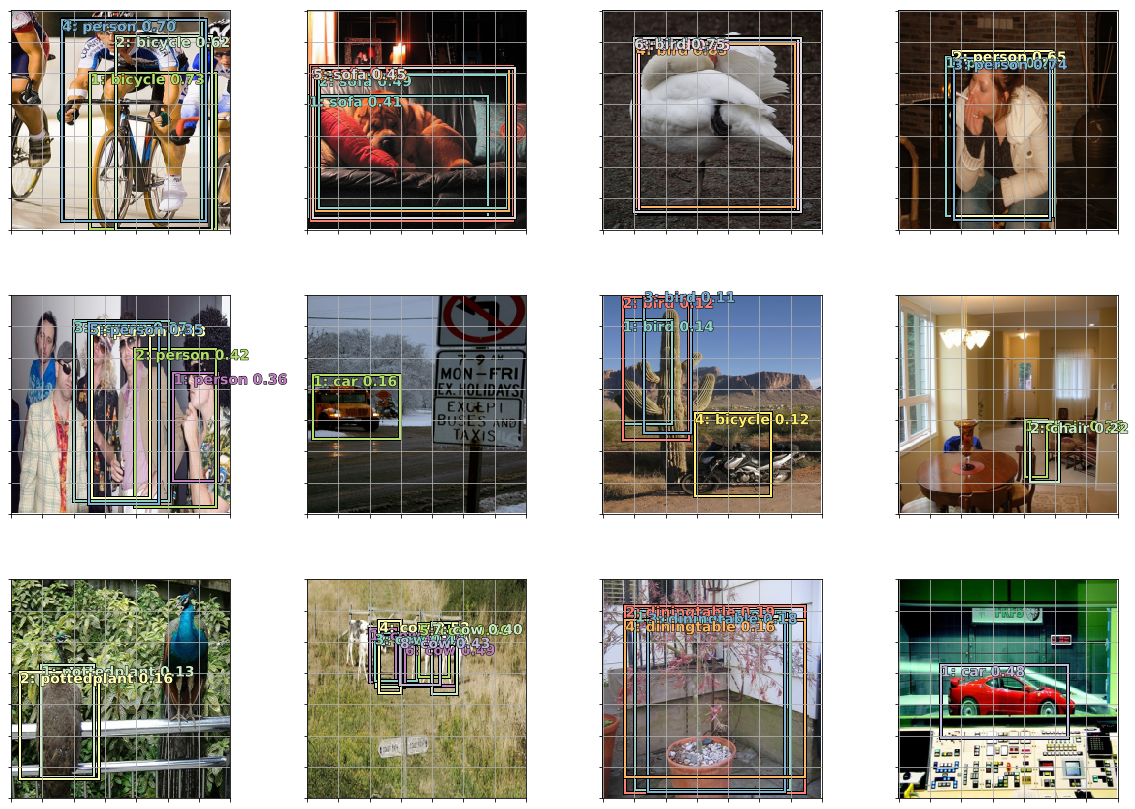

In [144]:
plot_results(0.75)

## Non Maximum Suppression

In [145]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

5: empty array
6: empty array
8: empty array
10: empty array


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


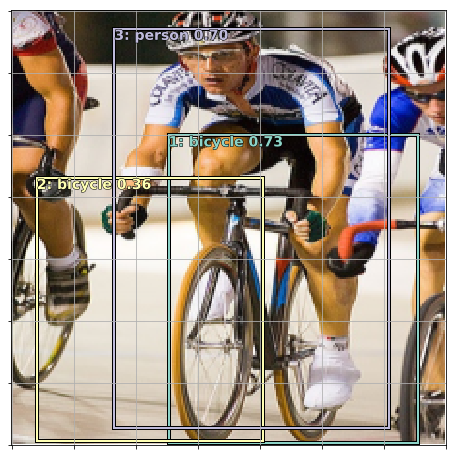

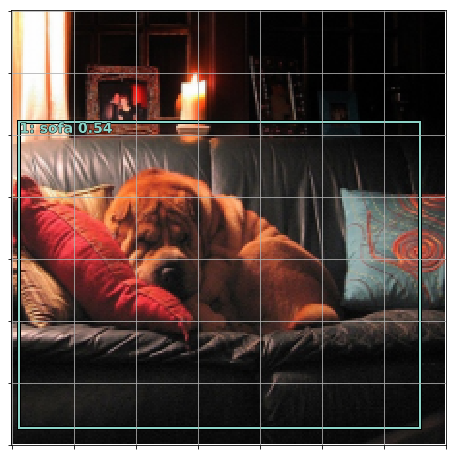

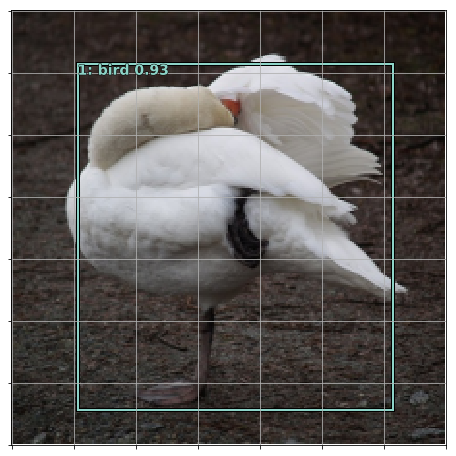

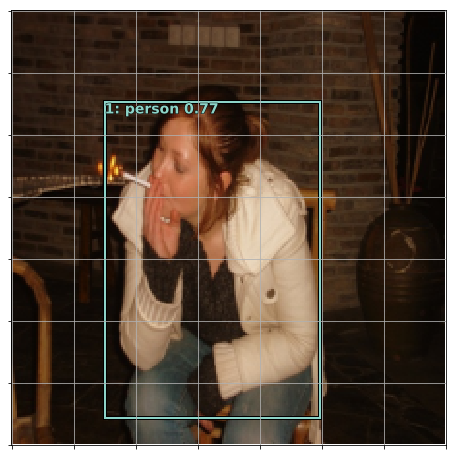

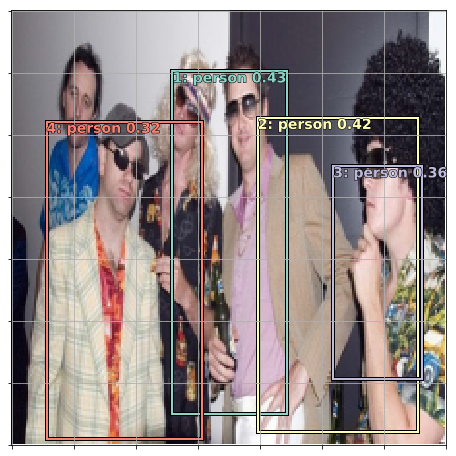

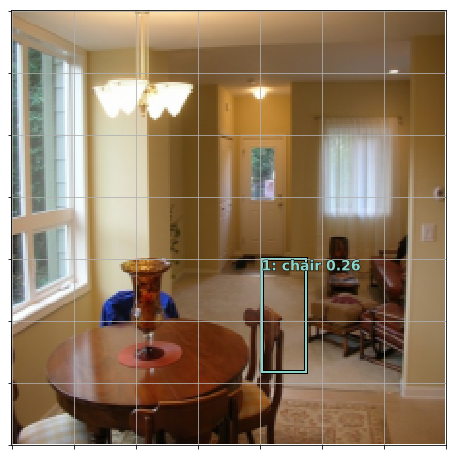

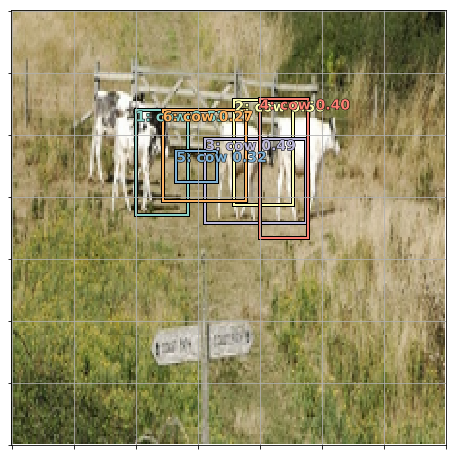

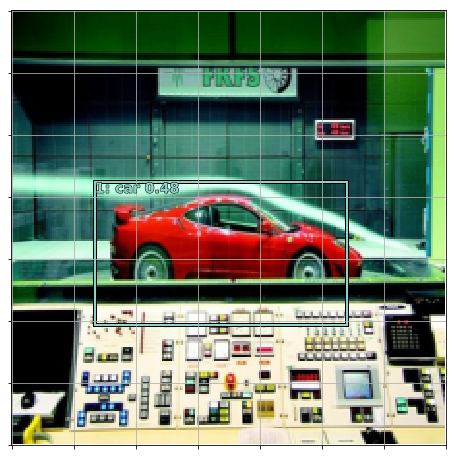

In [146]:
for i in range(12): show_nmf(i)